# Bandit Comparison: Zoom-In vs Standard Algorithms

### *Authors:* **Marvin Ernst, Oriol Gelabert, Melisa Vadenja**

Date: May 22, 2025

This notebook compares the performance of different bandit algorithms under a Lipschitz-Spatial Gaussian reward setting in 2D. We evaluate algorithms using instantaneous and cumulative regret metrics.

**Imports and setup:**

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..")))
from src import (
    generate_ground_truth,
    RegretTracker,
    GaussianUCB, GaussianTS,
    GaussianProcessUCB, GaussianProcessTS,
    get_zoomin_algorithm,
    plot_cumulative_regret, plot_instantaneous_regret, ensure_scalar, plot_arm_positions
)

**Simulation configuration:**

In [65]:
K = 500
T = 45000
D = 2
SIGMA = 0.001 # standard deviation of the noise in the reward distribution - VERY important for the performance of the algorithms!
N_RUNS = 1
LENGTH_SCALE = 1.0 # length scale for the GP prior = how quickly rewards change across space, highher = good arms are further from bad ones - very IMPORTANT!
SCALE_FACTOR = 1.0 # scale factor for the GP prior = how much the rewards vary across space, in total terms (not in distance (this is just a scalar) - (before 20.0)
BIAS = 0.0 # bias for the GP prior = how much the rewards are shifted up or down, in total terms (not in distance (this is just a constant) - (before 29.0)

# Strict Lipschitz with no noise (and strictly scaled to [0, 1] x [0, 1]) is Lipschitz with constant 1.0:
CUSTOM = True

### For the ZoomIn: ###

# smoothness constant: scale of the confidence radius - influences when a region is split. 
NU = 5.0   # smaller NU = more willing to split (i.e. assumes rewards change less across space) - we could make this up to 10 or bigger

# shrinking factor: how quickly regions shrink as the algorithm zooms in
RHO = 0.999 # smaller RHO = more aggressive shrinking

EXTRA_STEPS = T # how many extra steps after ZoomIn has locked into a region (put something different than T if you want this!)

algorithms_to_compare = {
    "ZoomIn": lambda f, arms: get_zoomin_algorithm(f, domain=[[0, 1], [0, 1]], rounds=T, nu=NU, rho=RHO),
    #"GP-UCB": lambda f, arms: GaussianProcessUCB(arms), # here we could also try with different length scales
    #"GP-TS": lambda f, arms: GaussianProcessTS(arms), # here we could also try with different length scales
    "UCB":    lambda f, arms: GaussianUCB(K),
    "TS":     lambda f, arms: GaussianTS(K)
}

**Example Bandits Space:**

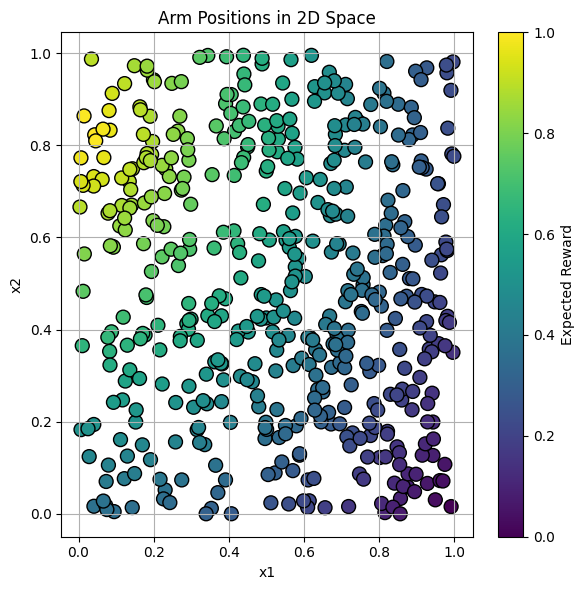

Best expected reward: 1.0
At position: [0.04306689 0.82270628]
Worst expected reward: 0.0
At position: [0.99216789 0.01585264]


In [66]:
X, mu, f = generate_ground_truth(K=K, d=2, sigma=SIGMA, random_state=0, length_scale=LENGTH_SCALE, scale_factor=SCALE_FACTOR, bias=BIAS, use_custom_f=CUSTOM)
plot_arm_positions(X, mu)

best_reward = np.max(mu)
worst_reward = np.min(mu)
best_arm_index = np.argmax(mu)
worst_arm_index = np.argmin(mu)
best_arm_position = X[best_arm_index]
worst_arm_position = X[worst_arm_index]

print("Best expected reward:", best_reward)
print("At position:", best_arm_position)
print("Worst expected reward:", worst_reward)
print("At position:", worst_arm_position)

**Run simulations:**


```
records = []

for run in trange(N_RUNS, desc="Simulation runs"):
    X, mu, f = generate_ground_truth(K=K, d=D, sigma=SIGMA, random_state=run, length_scale = LENGTH_SCALE, scale_factor=SCALE_FACTOR, bias=BIAS)

    for name, constructor in algorithms_to_compare.items():
        algo = constructor(f, X)
        tracker = RegretTracker(mu)

        for t in range(T):
            if name == "ZoomIn":
                x_t = algo.select_arm(t)
                x_array = np.atleast_2d(np.asarray(x_t, dtype=np.float64).flatten())
                a_t = np.argmin(np.linalg.norm(X - x_array, axis=1))
                reward = np.random.normal(f(x_array), SIGMA)
                algo.update(a_t, reward)
            else:
                a_t = algo.select_arm()
                reward = np.random.normal(mu[a_t], SIGMA) 
                algo.update(a_t, reward)

            tracker.update(a_t)

            records.append({
                'time': t + 1,
                'regret': tracker.get_cumulative_regret(),
                'algorithm': name,
                'run': run
            })
```


In [67]:
records = []

for run in trange(N_RUNS, desc="Simulation runs"):
    X, mu, f = generate_ground_truth(
        K=K, d=D, sigma=SIGMA, random_state=run,
        length_scale=LENGTH_SCALE, scale_factor=SCALE_FACTOR, bias=BIAS,
        use_custom_f=CUSTOM
    )

    algos = {name: constructor(f, X) for name, constructor in algorithms_to_compare.items()}
    trackers = {name: RegretTracker(mu) for name in algos}

    locked_in_detected = False
    locked_in_step = None

    for t in range(T):
        if locked_in_detected and t > locked_in_step + EXTRA_STEPS:
            print(f"Stopping run {run} at t={t} (locked in at {locked_in_step})")
            break

        for name, algo in algos.items():
            if name == "ZoomIn":
                x_t = algo.pull(t)
                x_array = np.atleast_2d(np.asarray(x_t, dtype=np.float64).flatten())
                a_t = np.argmin(np.linalg.norm(X - x_array, axis=1))
                reward = np.random.normal(f(x_array), SIGMA)
                algo.receive_reward(t, reward)

                if not locked_in_detected and getattr(algo, "locked_in_step", None) is not None:
                    locked_in_step = algo.locked_in_step
                    locked_in_detected = True
            else:
                a_t = algo.select_arm()
                reward = np.random.normal(mu[a_t], SIGMA)
                algo.update(a_t, reward)

            # regret check
            expected = mu[a_t]
            optimal = mu.max()
            regret = optimal - expected

            if regret > optimal - mu.min() + 1e-6:
                print(f"[Warning] t={t}, algo={name}, arm={a_t}, mu[a_t]={expected:.2f}, regret={regret:.2f}")
                print(f"mu.max()={optimal:.2f}, mu.min()={mu.min():.2f}")
                print(f"x_t={x_t}, x_array={x_array if name == 'ZoomIn' else 'N/A'}")
                assert False, "Regret exceeds theoretical maximum — likely incorrect arm index"

            # update tracker
            trackers[name].update(a_t)

            records.append({
                'time': t + 1,
                'regret': trackers[name].get_cumulative_regret(),
                'algorithm': name,
                'run': run
            })

Simulation runs: 100%|██████████| 1/1 [03:38<00:00, 218.63s/it]


**Convert and group data:**

In [68]:
df = pd.DataFrame(records)
df_avg = df.groupby(['algorithm', 'time']).regret.mean().reset_index()
df_avg.rename(columns={"regret": "avg_regret"}, inplace=True)
df_avg["avg_regret"] = df_avg["avg_regret"].apply(np.ravel).apply(lambda x: x[0] if isinstance(x, (np.ndarray, list)) else x)

**Plot cumulative regret:**

/Users/Admin/Library/Caches/pypoetry/virtualenvs/bandits-env-ro35Bmzw-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Admin/Library/Caches/pypoetry/virtualenvs/bandits-env-ro35Bmzw-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Admin/Library/Caches/pypoetry/virtualenvs/bandits-env-ro35Bmzw-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset

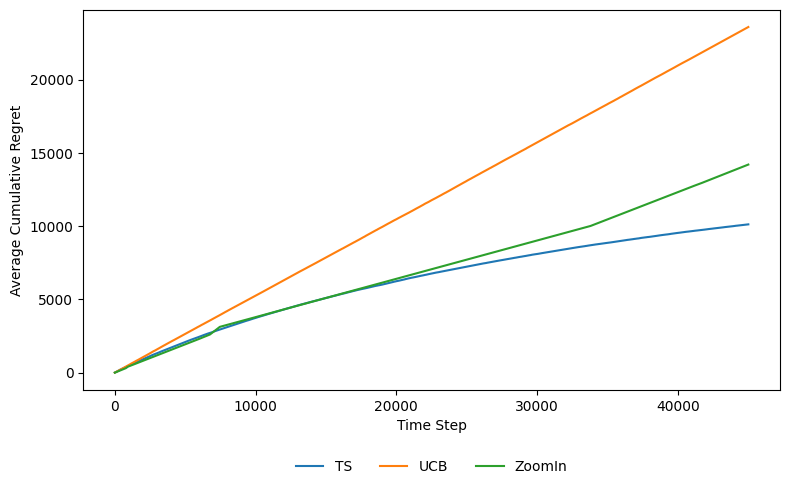

In [69]:
plot_cumulative_regret(df_avg)

**Instantaneous regret plot:**

/Users/Admin/Library/Caches/pypoetry/virtualenvs/bandits-env-ro35Bmzw-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Admin/Library/Caches/pypoetry/virtualenvs/bandits-env-ro35Bmzw-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Admin/Library/Caches/pypoetry/virtualenvs/bandits-env-ro35Bmzw-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset

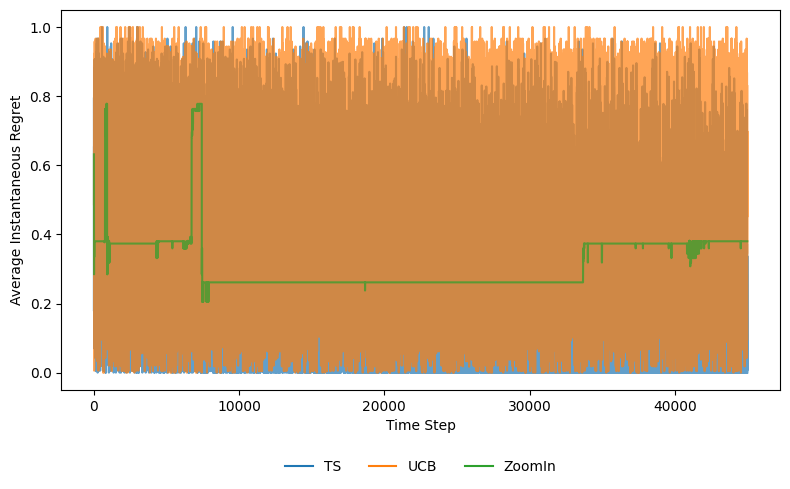

In [70]:
inst_df = pd.DataFrame(records)
inst_df.sort_values(["run", "algorithm", "time"], inplace=True)

inst_df["instantaneous_regret"] = inst_df.groupby(["run", "algorithm"])['regret'].diff().fillna(inst_df["regret"])

df_inst_avg = inst_df.groupby(['algorithm', 'time'])['instantaneous_regret'].mean().reset_index()
df_inst_avg.rename(columns={"instantaneous_regret": "avg_inst_regret"}, inplace=True)
df_inst_avg["avg_inst_regret"] = df_inst_avg["avg_inst_regret"].apply(ensure_scalar)
df_inst_avg.dropna(subset=["avg_inst_regret"], inplace=True)
df_inst_avg["avg_inst_regret"] = df_inst_avg["avg_inst_regret"].astype(float)

plot_instantaneous_regret(df_inst_avg)